# Exploration of the Weedle's Cave Data Set

## What's The Cave and why should I care?

Pokémon is a videogame series that has been around for over 20 years.<sup>1</sup> In it, people can test their strategic skills against one another by combating with beings called Pokémon; and [Weedle's Cave](https://www.kaggle.com/terminus7/pokemon-challenge) is a Kaggle dataset that contains the results of 50,000 such combats. The challenge is to predict future winners, which makes a lot of sense given the rise of eSports.<sup>2</sup> I, however, have a more fundamental reason to care for the dataset: 

<h5><center>**It's fun.** </center></h5>

Simply put, there's a lot of space to create features, create models and explore. All of this without taking into account player skill, the moves that each pokemon knows, or EVs/IVs,<sup>3</sup> which makes this problem very difficult to solve.

The fact that there are some very interesting lessons to find within The Cave makes the excercise worthwhile.

## The contents of the dataset.

Now that we know why we're doing this, let's take a look at the data we have to work with. The information is spread in two .csv files:

* combats.csv- It contains the Pokémon ids for the fighters and who won. Columns:
  1. First_pokemon: which Pokémon had the first turn;
  2. Second_pokemon: the other Pokémon involved in the fight and
  3. Winner: id of the victor of the combat.

* pokemon.csv- Database of the characteristics of each species of pokemon. Columns:
  1. #: Pokémon id. number;
  2. Name: Pokémon species's name;
  3. Type 1: Main pokemon type;
  4. Type 2: Secondary type (might be null);
  5. HP, Attack, Defense, Sp. Atk, Sp. Def, Speed: base stats for the species (health, attack, defense, special attack, special defense and speed, respectively);
  6. Generation: first videogame on which the species made its first appearance and
  7. Legendary: whether the pokemon is legendary (there's only one specimen in each copy of the videogame) or not


Let's get down to business.

<sup>1</sup>: "Pokemon", Wikipedia. https://en.wikipedia.org/wiki/Pokémon, consulted on 2018-06-02.

<sup>2</sup> : "Rise of eSports is a Game Changer", Huffington Post. https://en.wikipedia.org/wiki/Pokémon, consulted on 2018-06-02.

<sup>3</sup>: Effort Values (EVs) and Individual Values (IVs) are a complex system the game's developers made to try to make each pokemon unique, even when of the same species. I won't go into any detail, but if you want to learn more, the [Bulbapedia article on EVs](https://bulbapedia.bulbagarden.net/wiki/Effort_values) [and on Ivs](https://bulbapedia.bulbagarden.net/wiki/Individual_values) are great references.


## Condition of the database

### Combat information

In [2]:
%matplotlib inline
import pandas as pd

In [3]:
# path = path to where the data is saved.
combat_data = pd.read_csv(path + 'combats.csv')
print('Info:')
print(combat_data.info())
print('\nHead:')
print(combat_data.head())
print('\nTail:')
print(combat_data.tail())

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
First_pokemon     50000 non-null int64
Second_pokemon    50000 non-null int64
Winner            50000 non-null int64
dtypes: int64(3)
memory usage: 1.1 MB
None

Head:
   First_pokemon  Second_pokemon  Winner
0            266             298     298
1            702             701     701
2            191             668     668
3            237             683     683
4            151             231     151

Tail:
       First_pokemon  Second_pokemon  Winner
49995            707             126     707
49996            589             664     589
49997            303             368     368
49998            109              89     109
49999              9              73       9


In [4]:
# Consistency check: Is the winner always one of the pokemon that fought?
sum((combat_data.First_pokemon == combat_data.Winner) | (combat_data.Second_pokemon == combat_data.Winner))

50000

So there are no null values and the table looks good and is consistent. Now, there are some interesting questions we can ask.


#### Which pokemon do people fight with.

In [5]:
# Make a vector (pd.Series) with all the pokemon in the data set. 
all_the_poke = combat_data.First_pokemon.append(combat_data.Second_pokemon)
# Number of unique pokemon
print(u'Number of distinct Pokémon:')
print(all_the_poke.nunique())
# Number of incidences
print(u'\n10 most popular Pokémon:')
print(all_the_poke.value_counts().head(10))
print(u'\n10 least popular Pokémon:')
print(all_the_poke.value_counts().tail(10))

Number of distinct Pokémon:
784

10 most popular Pokémon:
163    164
344    160
667    159
214    158
758    158
79     157
762    156
690    156
374    155
579    154
dtype: int64

10 least popular Pokémon:
709    102
454    102
566    100
712    100
145     99
605     99
122     98
263     97
112     95
398     92
dtype: int64


#### Non informative cases

If two of the same Pokémon fought, we wouldn't gain any significant information from the "Winner" column, so we'll probably have to drop them when modelling.

In [6]:
sum(combat_data.First_pokemon == combat_data.Second_pokemon)

0

#### First turn advantage: Myth or reality

In [7]:
sum(combat_data.First_pokemon == combat_data.Winner) / float(len(combat_data))

0.47202

#### Matchup parity

Now, here comes two very important questions we need to adress: When the same two Pokémon fight, do we always observe the same victor? Does it depend on turn order? Note that if for any of those questions the answer is "No", we won't be able to completely separate the sets, i.e., we won't be able to predict with complete confidence the results when those two Pokémon fight.

The "real" way to test for this would be to loop through all combinations of combatants and see what information we have for those cases. The problem with this is that we'd have to loop through the

$$784 * 783 = 613,872$$

combinations and then do the same number of slices, which is quite unefficient. Instead, we'll count the cases where we saw the same combat combinations (same fighting order) with the same results, and compare them to the number of cases where the same to Pokémon fought.

In [8]:
# Number of repeat results
sum(combat_data.append(combat_data.rename(
    columns={'First_pokemon':'Second_pokemon',
             'Second_pokemon':'First_pokemon'})).duplicated())

7328

In [9]:
# To check the number of diferent times the same two pokemon fought we paste a copy of the DataFrame
# with inverted columns and check for duplicates
sum(combat_data.append(combat_data.rename(
    columns={'First_pokemon':'Second_pokemon',
             'Second_pokemon':'First_pokemon'}))[['First_pokemon','Second_pokemon']].duplicated())

7548

#### Results from the combat data exploration

1. There are no null values or inconsistencies in the data
2. There are 784 distinct Pokémon in the database, which is a bit light, but the difference could be from legendaries (which aren't allowed in tournaments). We'll follow up on this hypothesis later.
3. There are no cases where the same two Pokémon fought.
4. Not every case where the same combination Pokémon fought, the same Pokémon came out as a victor.
5. The dataset is balanced in the sense that if we use in a model the target variable

$$ 
\begin{cases} \text{1} &\quad\text{if first Pokemon won}\\ \text{0} &\quad\text{otherwise}\end{cases}
$$

    we'll have a similar number of 0s and 1s, meaning that we can use accuracy as the metric with which to test our model.
    
### Pokémon stats database.

Now, we'll change our focus to our auxiliary database, the one with all the stats and characteristics of the Pokémon.

#### Completeness

In [10]:
poke_data = pd.read_csv(path + 'pokemon.csv')
poke_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
#             800 non-null int64
Name          799 non-null object
Type 1        800 non-null object
Type 2        414 non-null object
HP            800 non-null int64
Attack        800 non-null int64
Defense       800 non-null int64
Sp. Atk       800 non-null int64
Sp. Def       800 non-null int64
Speed         800 non-null int64
Generation    800 non-null int64
Legendary     800 non-null bool
dtypes: bool(1), int64(8), object(3)
memory usage: 69.6+ KB


We notice a couple of things:

1. There's a null value in the Name column: while not technically a large problem, it's an easy one to solve.
2. About half of the Type 2 columns are nulls: this is to be expected because not all Pokémon have two types.
3. Some colmn names have special characters: again, not a large issue, but renaming a couple of columns can make the code a bit more readable.

To figure out the missing name, we could extract the unique names and compare them to a list of Pokémon names, but instead, a bit of domain-specific knowledge can come in handy.

In [11]:
# Number of missing name
missingno = poke_data.loc[poke_data.Name.isnull(),'#']
# Print the pokemon surrounding the missing data
poke_data[poke_data['#'].isin([missingno-1,missingno,missingno+1])]

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
61,62,Mankey,Fighting,NaN,40,80,35,35,45,70,1,False
62,63,NaN,Fighting,NaN,65,105,60,60,70,95,1,False
63,64,Growlithe,Fire,NaN,55,70,45,70,50,60,1,False


In [12]:
# This information is enough for us to infer that the missing Pokémon is Primeape. Let's corroborate.
('Primeape' in poke_data.Name.unique()) or ('primeape' in poke_data.Name.unique())

False

In [13]:
# This shows that the missing value is Primeape, so we'll add it to the missing data.
poke_data.loc[poke_data['#']==63,'Name'] = 'Primeape'

In [14]:
# Rename columns
colname_dict = {'#': 'Number',
                'Type 1': 'Type_1',
                'Type 2': 'Type_2',
                'Sp. Atk': 'Sp_Atk',
                'Sp. Def':'Sp_Def'}
poke_data = poke_data.rename(columns=colname_dict)

#### Consistency

In [15]:
# Are all numbers unique?
print('Minimum Number value: ' + str(poke_data.Number.min()) + ' Maximum Number value: ' + str(
    poke_data.Number.max()) + ' Distinct numbers: ' + str(poke_data.Number.nunique()))

Minimum Number value: 1 Maximum Number value: 800 Distinct numbers: 800


In [16]:
# Are there only 6 generations?
poke_data.Generation.value_counts()

1    166
5    165
3    160
4    121
2    106
6     82
Name: Generation, dtype: int64

In [17]:
# Are there 18 different types?
poke_data.Type_1.append(poke_data.Type_2).value_counts()

Water       126
Normal      102
Flying      101
Grass        95
Psychic      90
Bug          72
Ground       67
Fire         64
Poison       62
Rock         58
Fighting     53
Dark         51
Dragon       50
Electric     50
Steel        49
Ghost        46
Fairy        40
Ice          38
dtype: int64

In [18]:
# Are there otliers/ridiculous_values in the stats?
poke_data[['HP','Attack','Defense','Sp_Atk', 'Sp_Def','Speed']].describe()

,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,69.258750,79.001250,73.842500,72.820000,71.902500,68.277500
std,25.534669,32.457366,31.183501,32.722294,27.828916,29.060474
min,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,50.000000,55.000000,50.000000,49.750000,50.000000,45.000000
50%,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


In [19]:
# How many legendaries are there?
sum(poke_data.Legendary)

65

In [20]:
# Are there clearly over/underpowered Pokémon (removing legendaries)?
poke_data.loc[poke_data.Legendary==False,['HP','Attack','Defense','Sp_Atk','Sp_Def','Speed']].mean(
    axis=1).describe(percentiles=[.01,.05,.1,.25,.5,.75,.9,.95,.99])

count    735.000000
mean      69.535601
std       17.793403
min       30.000000
1%        33.333333
5%        41.666667
10%       46.666667
25%       54.000000
50%       70.833333
75%       83.000000
90%       89.166667
95%      100.000000
99%      105.666667
max      116.666667
dtype: float64

#### Results from Pokémon data exploration:

1. We found a couple of issues with the column names, which we fixed by renaming them.
2. There was a missing name, which we discovered was 'Primeape' and filled it in.
3. The rest of the data looks consistent in the sense that there are no odd values for generation, type or stats.
4. There are no clearly overpowered non-legendary Pokémon in the sense that there are no large spikes in average stats.

### Bringing both datasets together:

So far, we've explored the datasets independently of one another. It's time to merge them to have information on what Pokémon people actually fought with. 

In [21]:
full_data = combat_data.merge(poke_data, how='left',left_on='First_pokemon',right_on='Number')
full_data = full_data.merge(poke_data, how='left',left_on='Second_pokemon',
                            right_on='Number',suffixes=('_first','_second'))
full_data = full_data.drop('Number_first',axis=1)
full_data = full_data.drop('Number_second',axis=1)
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 25 columns):
First_pokemon        50000 non-null int64
Second_pokemon       50000 non-null int64
Winner               50000 non-null int64
Name_first           50000 non-null object
Type_1_first         50000 non-null object
Type_2_first         25969 non-null object
HP_first             50000 non-null int64
Attack_first         50000 non-null int64
Defense_first        50000 non-null int64
Sp_Atk_first         50000 non-null int64
Sp_Def_first         50000 non-null int64
Speed_first          50000 non-null int64
Generation_first     50000 non-null int64
Legendary_first      50000 non-null bool
Name_second          50000 non-null object
Type_1_second        50000 non-null object
Type_2_second        26015 non-null object
HP_second            50000 non-null int64
Attack_second        50000 non-null int64
Defense_second       50000 non-null int64
Sp_Atk_second        50000 non-null int64
Sp_D

In [22]:
full_data.head()

,First_pokemon,Second_pokemon,Winner,Name_first,Type_1_first,Type_2_first,HP_first,Attack_first,Defense_first,Sp_Atk_first,...,Type_1_second,Type_2_second,HP_second,Attack_second,Defense_second,Sp_Atk_second,Sp_Def_second,Speed_second,Generation_second,Legendary_second
0,266,298,298,Larvitar,Rock,Ground,50,64,50,45,...,Grass,Dark,70,70,40,60,40,60,3,False
1,702,701,701,Virizion,Grass,Fighting,91,90,72,90,...,Rock,Fighting,91,129,90,72,90,108,5,True
2,191,668,668,Togetic,Fairy,Flying,55,40,85,80,...,Psychic,NaN,75,75,75,125,95,40,5,False
3,237,683,683,Slugma,Fire,NaN,40,40,40,70,...,Dragon,NaN,77,120,90,60,90,48,5,False
4,151,231,151,Omastar,Rock,Water,70,60,125,115,...,Bug,Rock,20,10,230,10,230,5,2,False


In [23]:
full_data[['HP_first','Attack_first','Defense_first','Sp_Atk_first', 'Sp_Def_first','Speed_first',
           'HP_second','Attack_second','Defense_second','Sp_Atk_second', 'Sp_Def_second','Speed_second',]].describe()

,HP_first,Attack_first,Defense_first,Sp_Atk_first,Sp_Def_first,Speed_first,HP_second,Attack_second,Defense_second,Sp_Atk_second,Sp_Def_second,Speed_second
count,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,69.06692,79.121040,74.248540,72.893900,72.077020,68.214420,69.099940,79.035100,74.148600,72.664220,72.018440,68.279220
std,25.27720,32.690876,31.635322,32.745608,27.916398,29.288297,25.170108,32.413583,31.578308,32.644598,27.836053,29.108555
min,1.00000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000
25%,50.00000,55.000000,50.000000,50.000000,50.000000,45.000000,50.000000,55.000000,50.000000,50.000000,50.000000,45.000000
50%,65.00000,75.000000,70.000000,65.000000,70.000000,65.000000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000
75%,80.00000,100.000000,90.000000,95.000000,90.000000,90.000000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000
max,255.00000,190.000000,230.000000,194.000000,230.000000,180.000000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000


In [24]:
full_data.iloc[42]

First_pokemon               376
Second_pokemon              135
Winner                      376
Name_first               Baltoy
Type_1_first             Ground
Type_2_first            Psychic
HP_first                     40
Attack_first                 40
Defense_first                55
Sp_Atk_first                 40
Sp_Def_first                 70
Speed_first                  55
Generation_first              3
Legendary_first           False
Name_second          Electabuzz
Type_1_second          Electric
Type_2_second               NaN
HP_second                    65
Attack_second                83
Defense_second               57
Sp_Atk_second                95
Sp_Def_second                85
Speed_second                105
Generation_second             1
Legendary_second          False
Name: 42, dtype: object

With the merged data, we can start looking at our feature space.

In [25]:
# Do legendaries fight non-legendaries?
cond_first = full_data.Legendary_first # Cases where the first Pokémon is legendary.
cond_second = full_data.Legendary_second # Cases where the second Pokémon is legendary.
cond_first_n_second = cond_first & ~cond_second # Cases where the first Pokémon is legendary but not the second one.
cond_n_first_second = ~cond_first & cond_second # Cases where only the second Pokémon is legendary.
print('Number of battles that included a legendary:')
print(sum(cond_first | cond_second))
print('Number of battles between two legendaries')
print(sum(cond_first & cond_second))
print('Number of battles between legendary and not legendary')
print(sum(cond_first_n_second | cond_n_first_second))

Number of battles that included a legendary:
7839
Number of battles between two legendaries
349
Number of battles between legendary and not legendary
7490


In [26]:
# What Pokémon are missing from combat_data?
not_in_combat = set(poke_data.Number.unique()) - set(all_the_poke.unique())
poke_data[poke_data.Number.isin(not_in_combat)]

,Number,Name,Type_1,Type_2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,Legendary
11,12,Blastoise,Water,NaN,79,83,100,85,105,78,1,False
32,33,Sandshrew,Ground,NaN,50,75,85,20,30,40,1,False
45,46,Wigglytuff,Normal,Fairy,140,70,45,85,50,45,1,False
65,66,Poliwag,Water,NaN,40,50,40,40,40,90,1,False
77,78,Victreebel,Grass,Poison,80,105,65,100,70,70,1,False
89,90,Magneton,Electric,Steel,50,60,95,120,70,70,1,False
143,144,Ditto,Normal,NaN,48,48,48,48,48,48,1,False
182,183,Ariados,Bug,Poison,70,90,70,60,60,40,2,False
235,236,Ursaring,Normal,NaN,90,130,75,75,75,55,2,False
321,322,Hariyama,Fighting,NaN,144,120,60,40,60,50,3,False


#### Results from merged data

With the merged data, we now know that the hypotesis that missing Pokémon are legendary is false. In fact, there are 7,400 cases were a legendary fought a non-legendary. We also note that there are no missing values in the dataset, except for the secondary type of the Pokémon, but we weren't able to use those features as they are anyway, so that's also not a problem. An interesting note is that none of the stats are negative or equal to 0, which means that we can do any transformation we want to when looking for features for our model. Finally, the Pokémon that are missing from combat_data are o many types, generations and cover a wide array of stats, so there are no particularly obvious holes in our data.

## Conclusions and Next steps

So far we've covered a lot of ground getting to know our dataset. We have discovered several important things, among which are that:

1. The data is relatively clean and whith no un-recoverable missing data.
2. There are no large gaps in information.
3. The dataset is balanced.
4. We'll need to transform the data to make the Type_1 and Type_2 categorical variables so that we can use them as features.
5. The range and completeness of the stats allow us to use almost any transformation of them as possible features.

Now, we're ready to start building models capable of predicting winners of battles. The process will follow three steps. First, we'll do some feature engineering, in which we'll try to find relationships between the stats and the winner of the combat. Next, we'll proceed to select the features that we find are most useful to predict results. Finally, we'll try several diferent models and use their accuracy to compare them

## Appendix A: Visualizations that, although potentially interesting, aren't strictly relevant to our use case.

In this notebook I haven't produced any visualizations because there hasn't been much need for them. To me it's easier to see that there are roughly a third of ice-type Pokémon than water-type Pokémon for looking at the numbers than looking at a bar plot. Additionally, most visualizations I can think of are useful when exploring Pokémon stats in the abstract, which isn't the goal of our model (we strive to capture how stats/types, etc. match up one against the other in combat).

For these reasons, I felt visualizations haven't been necesary in the body of this research log, but I did produce some, part out of curiosity, part because I didn't know if I'd need them. In this appendix I'll show the visualizations I worked on because I think they can give us interesting insights on Pokémon stats, although I'll leave it to the reader to play around with some of the plots I made and come up with their own conclusions.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10844c610>,
      dtype=object)

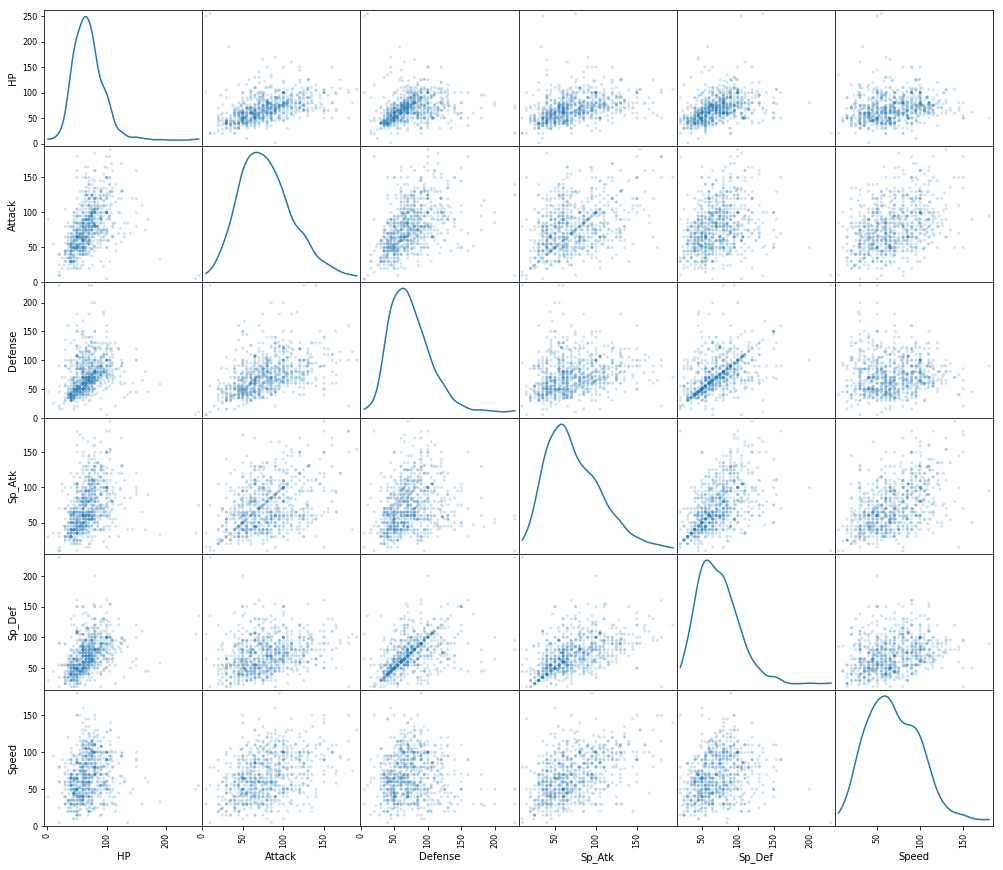

In [27]:
# Scatter matrix for stats
pd.plotting.scatter_matrix(poke_data[['HP','Attack','Defense','Sp_Atk', 'Sp_Def','Speed']],
                           alpha=0.2, figsize=(17, 15), diagonal='kde')

Text(0.5,0,u'Pok\xe9mon Type')

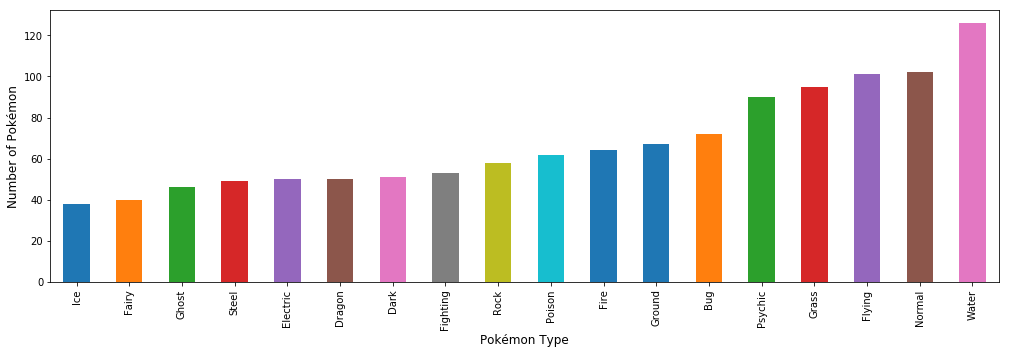

In [28]:
# Types of Pokémon
ax = poke_data.Type_1.append(poke_data.Type_2).value_counts().sort_values(
    ascending=True).plot(kind='bar', figsize=(17,5))
ax.set_ylabel(u'Number of Pokémon',size=12)
ax.set_xlabel(u'Pokémon Type',size=12)

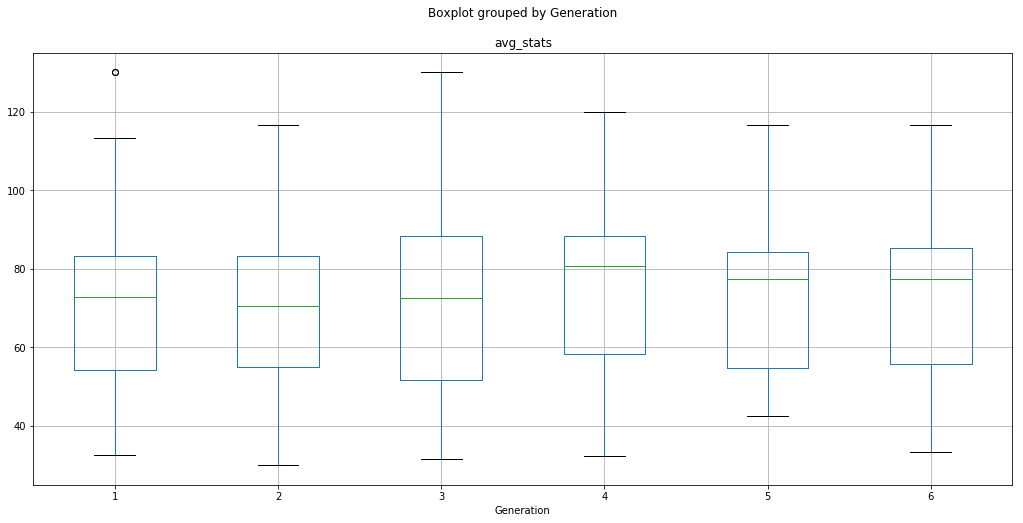

In [30]:
# Power creep: Are later generations "more powerful" than earlier ones?
poke_data['avg_stats'] = poke_data[['HP','Attack','Defense','Sp_Atk','Sp_Def','Speed']].mean(axis=1)

poke_data[['Generation','avg_stats']].boxplot(by='Generation',column='avg_stats', figsize=(17, 8))

In [32]:
# Distribution of a stat by type:
for_stat_distb = poke_data.drop('Type_2',axis=1)
for_stat_distb = for_stat_distb.append(poke_data[poke_data.Type_2.notnull()].drop(
    'Type_1',axis=1).rename(columns={'Type_2':'Type_1'})).rename(columns={'Type_1':'Type'})

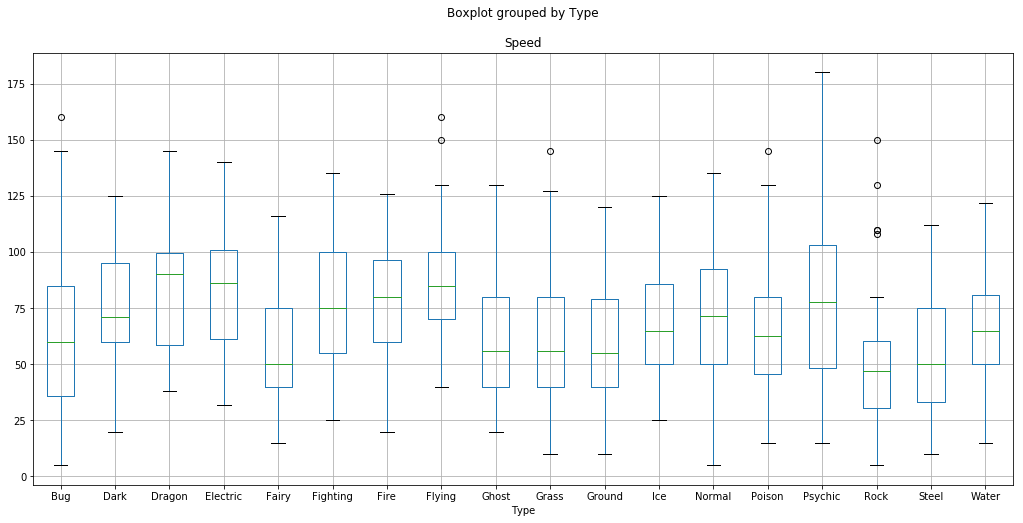

In [33]:
stat = 'Speed'
for_stat_distb[['Type',stat]].boxplot(by='Type',column=stat, figsize=(17, 8))

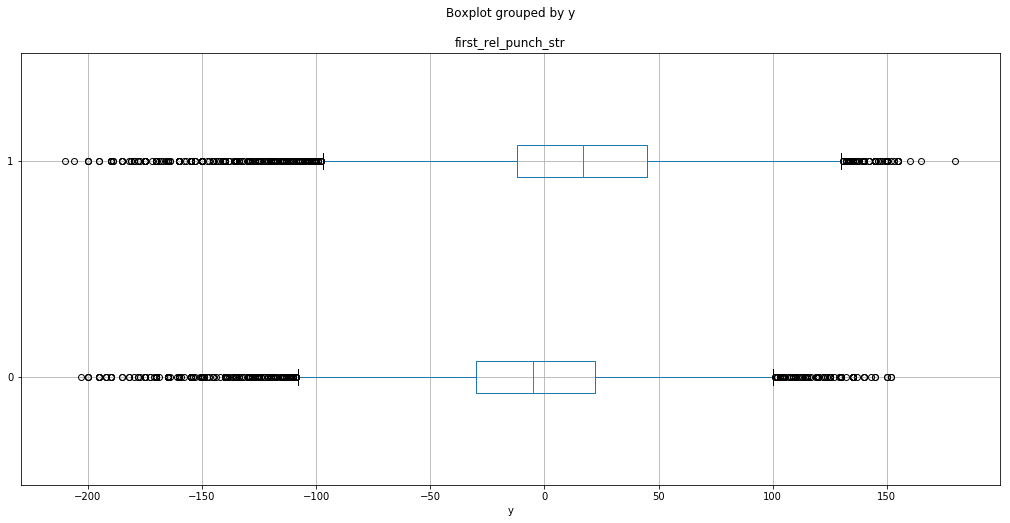

In [35]:
# A glimpse to the future: How to select features
# First we'll need the target variable
full_data['y'] = full_data.Winner == full_data.First_pokemon
full_data['y'] = full_data.y.astype(int)
# Now, well choose a feature, say the "First Pokémon relative punch strength", defined as (Attack_first - Defense_second)
full_data['first_rel_punch_str'] = full_data.Attack_first - full_data.Defense_second
# And we'll use a boxplot to check if the distribution of the feature behaves differently in each of the final categories
full_data.boxplot(by='y',column='first_rel_punch_str', figsize=(17, 8), vert=False)
# We can complement the boxplot with a simple logistic regression to estimate the effect and p-value of the feature 
# will have in a final model.